# Age Detection of Customers

The "Bread and Salt" network supermarket is implementing a computer vision system to process customer photos. Photo capture in the checkout area will help determine the age of customers in order to:

- Analyze purchases and suggest products that may be of interest to customers in this age group;
- Monitor the honesty of cashiers when selling alcohol. 

The task is to build a model that will determine the approximate age of a person from a photograph. We have a set of photographs of people with their ages specified.

The key metric is **MAE, with a threshold value of 8**.

To control randomness, we will set the **random_state parameter to 12345**.

## Data Preparation
I will import the necessary libraries, set the necessary options and constants.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.simplefilter('ignore')

SEED = 12345
THRESHOLD_MAE = 8

Let's save the data into dataframe.

In [17]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Let's output general information about each dataframe, as well as its first and last 5 rows.

In [18]:
display(labels.info())

labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


There are 7591 annotated photos. Let's move on.

We will perform dynamic data loading.

In [19]:
train_datagen = ImageDataGenerator(validation_split=0.25, 
                                  rescale=1/255,
                                  horizontal_flip=True
)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


We will find out the dimension of the features.

In [20]:
features_train, target_train = next(train_gen_flow)

print(features_train.shape)

(32, 224, 224, 3)


The features are a four-dimensional tensor, in which 32 images are of size 224x224 with three color channels.

### Analysis of the age distribution in the sample
Let's study the age data.

In [21]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


- В датасете представлены фотографии людей в возрасте от 1 года до 100 лет;
- медиана составляет 29 лет, среднее значение - 31.2 года.

- The dataset contains photos of people aged 1 to 100 years;
- The median is 29 years, and the mean is 31.2 years.

We will build a histogram of the age of people in the photos, as well as graphs of the distribution of age groups and age decades.

First, let's write a function that will group people in age groups based on their photos.

In [22]:
def categorizer1(age):
    if age <= 1:
        return 'infants'
    if age < 7:
        return 'preschoolers'
    if age <= 10:
        return 'schoolchildren'
    if age <= 17:
        return 'teenagers'
    if age <= 35:
        return 'young adults'
    if age <= 60:
        return 'middle-aged adults'
    if age <= 75:
        return 'elderly'
    if age <= 90:
        return 'old'
    if age <= 100:
        return 'long-lived'
    else: 'long-lived'

Next, we will write a function that will group people into age decades based on their photos.

In [23]:
def categorizer2(age):
    if age <= 10:
        return '1-10'
    if age <= 20:
        return '11-20'
    if age <= 30:
        return '21-30'
    if age <= 40:
        return '31-40'
    if age <= 50:
        return '41-50'
    if age <= 60:
        return '51-60'
    if age <= 70:
        return '61-70'
    if age <= 80:
        return '71-80'
    if age <= 90:
        return '81-90'
    else: '91-100'

We will add information about age groups and decades to a copy of our dataframe.

In [24]:
labels_copy = labels.copy()

labels_copy['age_category'] = labels_copy['real_age'].apply(categorizer1)
labels_copy['age_decade'] = labels_copy['real_age'].apply(categorizer2)

labels_copy

,file_name,real_age,age_category,age_decade
0,000000.jpg,4,preschoolers,1-10
1,000001.jpg,18,young adults,11-20
2,000002.jpg,80,old,71-80
3,000003.jpg,50,middle-aged adults,41-50
4,000004.jpg,17,teenagers,11-20
...,...,...,...,...
7586,007608.jpg,14,teenagers,11-20
7587,007609.jpg,37,middle-aged adults,31-40
7588,007610.jpg,28,young adults,21-30
7589,007611.jpg,20,young adults,11-20


We will count the number of photos for each age group and decade and write the resulting information to new dataframes for plotting.

In [25]:
labels_copy['age_category'].value_counts()

young adults          3515
middle-aged adults    2127
teenagers              795
preschoolers           369
elderly                310
schoolchildren         190
infants                149
old                    123
long-lived              13
Name: age_category, dtype: int64

In [26]:
age_category = pd.DataFrame(columns=['count'],
                           data=[149, 369, 190,
                                  795, 3515, 2127,
                                  310, 123, 13])
                            
age_category['category'] = ['infants', 'preschoolers', 'schoolchildren',
                            'teenagers', 'young adults', 'middle-aged adults',
                            'elderly', 'old', 'long-lived']
    
age_category

,count,category
0,149,infants
1,369,preschoolers
2,190,schoolchildren
3,795,teenagers
4,3515,young adults
5,2127,middle-aged adults
6,310,elderly
7,123,old
8,13,long-lived


In [27]:
labels_copy['age_decade'].value_counts()

21-30    2214
31-40    1414
11-20    1346
41-50     929
1-10      708
51-60     534
61-70     254
71-80     111
81-90      68
Name: age_decade, dtype: int64

In [28]:
age_decade = pd.DataFrame(columns=['count'],
                           data=[708, 1346, 2214, 1414, 929, 
                                 534, 254, 111, 68, 13])
                            
age_decade['decade'] = ['1-10','11-20','21-30','31-40','41-50',
                                 '51-60','61-70','71-80','81-90','91-100']

age_decade

,count,decade
0,708,1-10
1,1346,11-20
2,2214,21-30
3,1414,31-40
4,929,41-50
5,534,51-60
6,254,61-70
7,111,71-80
8,68,81-90
9,13,91-100


Let's plot the graphs.

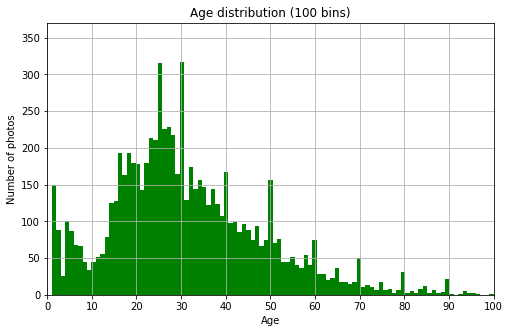

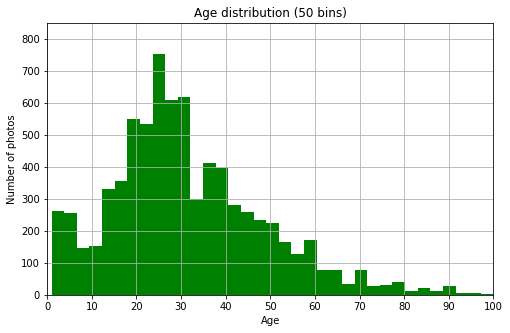

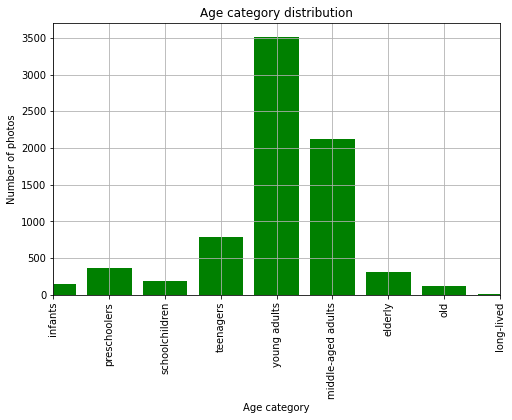

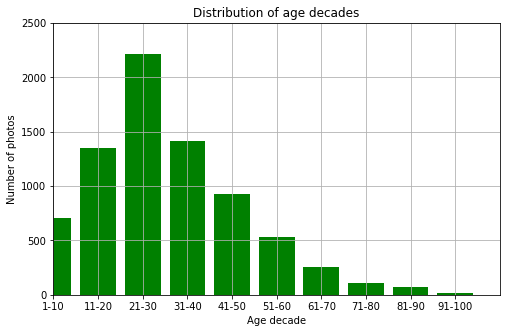

In [29]:
fig = plt.figure(figsize = (8, 5))

n, bins, patches = plt.hist(labels['real_age'], 100, facecolor='g')

plt.xlabel('Age')
plt.xticks(list(range(0,101,10)))
plt.ylabel('Number of photos')
plt.title('Age distribution (100 bins)')
plt.xlim(0, 100)
plt.ylim(0, 370)
plt.grid(True)
plt.show()

fig = plt.figure(figsize = (8, 5))

n, bins, patches = plt.hist(labels['real_age'], 35, facecolor='g')

plt.xlabel('Age')
plt.xticks(list(range(0,101,10)))
plt.ylabel('Number of photos')
plt.title('Age distribution (50 bins)')
plt.xlim(0, 100)
plt.ylim(0, 850)
plt.grid(True)
plt.show()

fig = plt.figure(figsize = (8, 5))

plt.bar(age_category['category'], age_category['count'], color ='green')

plt.xlabel('Age category')
plt.xticks(rotation=90)
plt.ylabel('Number of photos')
plt.title('Age category distribution')
plt.xlim(0, 8)
plt.ylim(0, 3700)
plt.grid(True)
plt.show()

fig = plt.figure(figsize = (8, 5))

plt.bar(age_decade['decade'], age_decade['count'], color ='green')

plt.xlabel('Age decade')
plt.ylabel('Number of photos')
plt.title('Distribution of age decades')
plt.xlim(0, 10)
plt.ylim(0, 2500)
plt.grid(True)
plt.show()

Conclusion:

- The data frame contains the most photographs of young people (18-35 years old) - more than 3500; 
- over 2200 photographs of people aged 21 to 30 - i.e., two-thirds of young people; 
- there is also a large number of middle-aged people - more than 2000 - and teenagers - almost 800 people; 
- the smallest number of old people and centenarians - 123 and 13 people, respectively; 
- on the age distribution graph with 100 bins, peaks around "milestone" years (30, 40, 50...) are noticeable. 

Thus, part of the age distribution graph from 20 to 100 years resembles the age distribution [graph](http://www.demoscope.ru/weekly/2017/0735/barom06.php) of the world population. The values for ages under 20 on our graphs are much smaller than proportional values for the corresponding range on the world population age distribution graph.

However, it should be noted that children under the teenage age group rarely go to stores, and teenagers, although they visit them more often, still less frequently than representatives of older age categories.

As for the "milestone" year peaks observed on the first graph, they are most likely associated with the fact that the actual age was unknown for some photos, so the age was rounded when annotating the dataset for such photos. It is not possible to determine which specific photos were annotated in this way, but at the same time, their quantity, judging by the graph, is no more than 10% of the dataset with the most pessimistic estimate. Therefore, we assume that these photos will not distort the research results.

**The age data is fine**.

### Image analysis in the sample
Let's output the first 30 photographs from the training set. The age will also be displayed for each image.

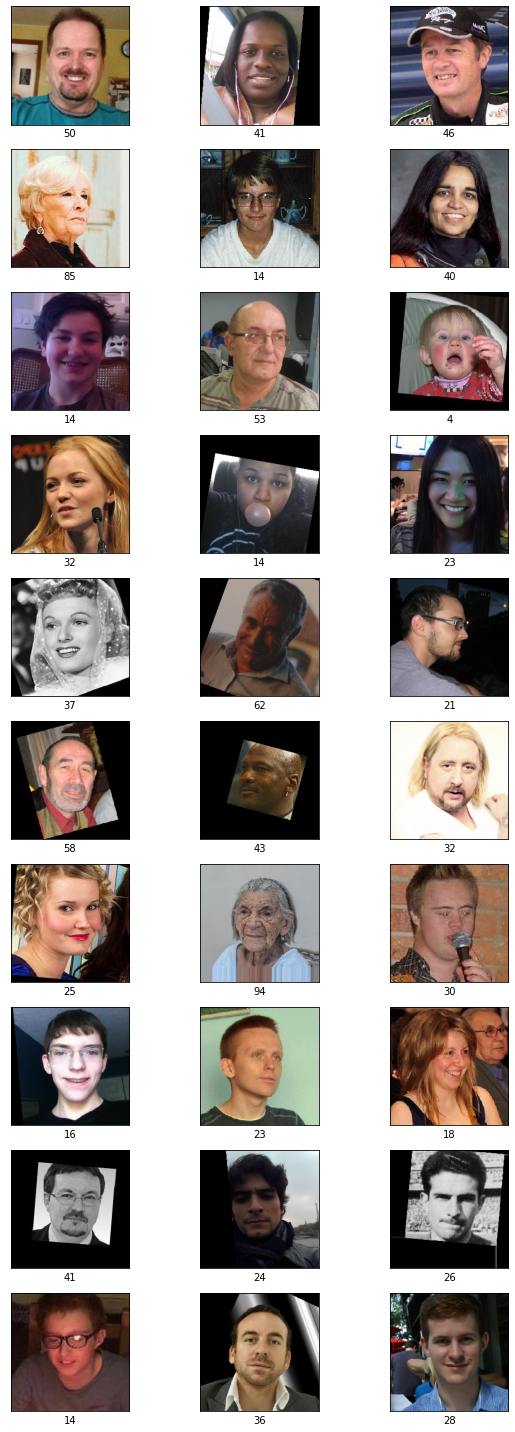

In [30]:
fig = plt.figure(figsize=(10,20))

for i in range(30):
    fig.add_subplot(10, 3, i+1)
    plt.imshow(features_train[i])
    plt.xlabel(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- Among the printed photographs, colored ones in acceptable quality where the face is clearly visible prevail - 22/30 of such photos; 
- there are also 3 black and white photos - where the face is also clearly visible; 
- on 5 photographs, either the head is turned to the side, or the face is covered with various objects (chewing gum, microphone, glasses with a glare on the lens).

Thus, the faces are clearly visible on 25 out of 30 photographs - 83%. **Everything is fine with the photos**.

### Conclusion from the research
The study showed that both with the photographs from the sample and the age distribution in the data frame, everything is fine - i.e., **there are no moments that could distort the quality of the model training**.

We proceed to the model training.

## Model training
Training neural networks on a central processor takes a lot of time, especially when training a neural network to solve computer vision tasks. Therefore, graphics processing units are used to train models, which significantly accelerate the process.

In connection with this, the model was trained on a server with a graphics card (GPU) from Yandex Compute Cloud.

Below is the training code and the model output that was generated by the server.

### Training Code

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1/255,
                                      horizonal_flip=True
                                      )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255
                                 )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

### Model output

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-01-23 14:58:41.404725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-23 14:58:43.654546: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 254.2518 - mean_absolute_error: 11.3537 - val_loss: 935.2881 - val_mean_absolute_error: 25.7789
Epoch 2/10
178/178 - 37s - loss: 66.2311 - mean_absolute_error: 6.0782 - val_loss: 574.5150 - val_mean_absolute_error: 18.6635
Epoch 3/10
178/178 - 37s - loss: 30.5144 - mean_absolute_error: 4.2729 - val_loss: 410.4727 - val_mean_absolute_error: 15.6228
Epoch 4/10
178/178 - 37s - loss: 19.6248 - mean_absolute_error: 3.4330 - val_loss: 109.5453 - val_mean_absolute_error: 8.0929
Epoch 5/10
178/178 - 37s - loss: 14.5446 - mean_absolute_error: 2.9405 - val_loss: 76.6314 - val_mean_absolute_error: 6.6024
Epoch 6/10
178/178 - 37s - loss: 11.0316 - mean_absolute_error: 2.5750 - val_loss: 69.4230 - val_mean_absolute_error: 6.4612
Epoch 7/10
178/178 - 37s - loss: 9.3778 - mean_absolute_error: 2.3248 - val_loss: 65.4337 - val_mean_absolute_error: 6.2409
Epoch 8/10
178/178 - 37s - loss: 8.4245 - mean_absolute_error: 2.2035 - val_loss: 62.4243 - val_mean_absolute_error: 5.9588
Epoch 9/10
178/178 - 37s - loss: 8.0488 - mean_absolute_error: 2.1464 - val_loss: 72.1791 - val_mean_absolute_error: 6.6550
Epoch 10/10
178/178 - 37s - loss: 6.7333 - mean_absolute_error: 1.9674 - val_loss: 72.4425 - val_mean_absolute_error: 6.3746
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 72.4425 - mean_absolute_error: 6.3746
Test MAE: 6.3746


```

## Analysis of the trained model:

The metric of the trained model's predictions on the test set was 6.37, which is below the threshold value of 8. This means that on average, the model makes an error of 6.37 years when determining a person's age from a photo. This may seem like a large number, and the model may appear to be inaccurate. However, it is important to revisit the project description, which outlines the specific tasks that the model is expected to perform:

- Analyze purchases and suggest products that may be of interest to people in this age group.
- Monitor cashiers' compliance when selling alcohol.

Therefore, the MAE value may not seem as large, because:

- The first task implies that the model needs to suggest products to people of a certain **age group**, which suggests a range of values rather than a specific age (number). Moreover, the range is likely to be greater than 8 years.
- The second task implies that the model needs to **clearly distinguish between children and non-children**. I believe that the model can perform this task correctly. Most of the errors that the model made were likely due to:
 - Comparing adults who may look completely different at the same age, which may have led the model to determine their age incorrectly.
 - Comparing children, as children and mature adults can look very different at the same age.
- Returning to the second task, based on the arguments outlined above, I am confident that the model can distinguish between adults and children accurately. However, regarding people between the ages of 18 and 25, the model may make mistakes. This is normal, as the age of 18 is only a basic threshold for humans, while machines cannot accurately distinguish, for example, a 17-year-old young man with a beard from a 19-year-old (just like we sometimes cannot).

Nevertheless, to summarize, **we can consider the model successful**, and the MAE value acceptable, considering the specific tasks for which the model was designed and how well it performs on them.

**Recommendations**:

- In the future, I recommend improving the model by retraining it on a dataset with a larger number of photos of children, adolescents, and young adults aged 18 to 25, so that the model can distinguish children from non-children even more accurately. In addition, the dataset should include a large block of photos of teenagers with mustaches, beards, and those who just look mature to the human eye, as well as photos of 18-25 year-olds who look young enough. Perhaps in this way, the model will learn to determine the age of such people not only based on external factors but more deeply;
- It is also recommended to conduct additional testing (both for the current model and for the new model if retraining is conducted), in which the models will be given exclusively/mostly photos of people aged 12 to 25;
- Furthermore, to increase the quality of the model's predictions, in case of retraining, it is recommended to use a dataset that lacks or almost lacks rounded labeled data (when the age of the person in the photo is not indicated, and the data engineer or other person responsible for labeling the data provides an approximate age).